Label distribution:
Sad: 324 images
Fear: 324 images
Surprise: 321 images
Neutral: 81 images
Anger: 324 images
Joy: 324 images
Disgust: 324 images
Running configuration: No Data Augmentation
Test Accuracy: 64.44%
Precision: 0.94
Recall: 0.89
F1 Score: 0.92

Summary of Results:
Configuration 1: No Data Augmentation
Test Accuracy: 64.44%
Precision: 0.94
Recall: 0.89
F1 Score: 0.92


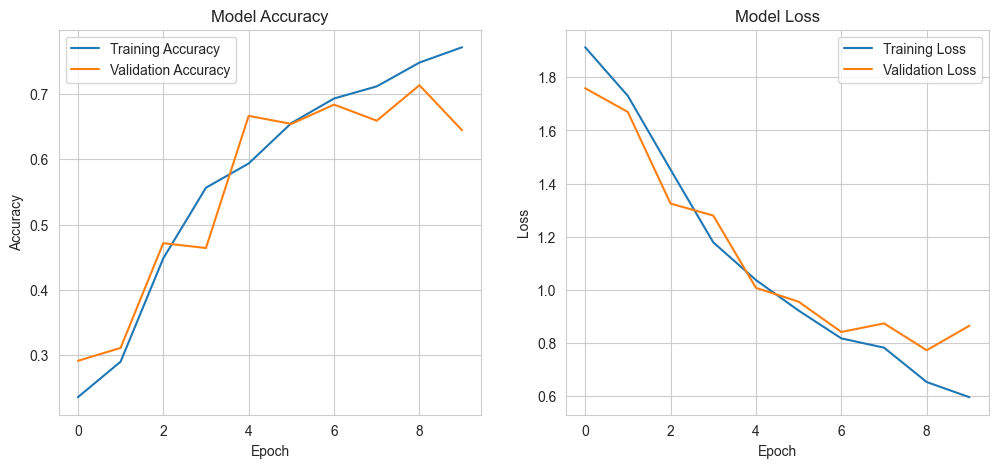

In [2]:
import os
import random
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from collections import Counter
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, InputLayer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
tf.get_logger().setLevel('ERROR')

# Set seeds for reproducibility
def set_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.keras.utils.set_random_seed(seed)
    tf.config.experimental.enable_op_determinism()

set_seeds(42)

# Define the path to the BU_3DFE dataset folder
dataset_folder = r'/Users/Downloads/linda_trials/BU_3DFE_Database_sorted'

# Function to load images and extract labels
def load_images_and_labels(base_folder):
    images = []
    labels = []
    for label_folder in os.listdir(base_folder):
        label_path = os.path.join(base_folder, label_folder)
        if os.path.isdir(label_path):
            for filename in os.listdir(label_path):
                if filename.endswith('.bmp'):  # Check for .bmp files
                    image_file = os.path.join(label_path, filename)
                    img = Image.open(image_file).convert('L')  # Convert to grayscale
                    img = img.resize((64, 64))  # Resize to 64x64 for consistency
                    img_array = np.array(img) / 255.0  # Normalize pixel values to [0, 1]
                    images.append(img_array)
                    labels.append(label_folder)  # The folder name is the label
    return np.array(images), np.array(labels)

# Load images and labels
images, labels = load_images_and_labels(dataset_folder)
images = images.reshape(-1, 64, 64, 1)  # Reshape for CNN input

# Display some sample images with their labels
num_samples = 5
plt.figure(figsize=(10, 2))
for i in range(num_samples):
    plt.subplot(1, num_samples, i+1)
    plt.imshow(images[i].reshape(64, 64), cmap='gray')
    plt.title(f"BU Sample {i+1}\nLabel: {labels[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# Check for class imbalance
label_counts = Counter(labels)
print("Label distribution:")
for label, count in label_counts.items():
    print(f"{label}: {count} images")

# Convert labels to one-hot encoding
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_categorical = to_categorical(labels_encoded)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels_categorical, test_size=0.2, random_state=42)

# Calculate class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels_encoded),
    y=labels_encoded
)
class_weights_dict = dict(enumerate(class_weights))

# Define the CNN architecture function
def create_model():
    model = Sequential([
        InputLayer(input_shape=(64, 64, 1)),  # Input layer for 64x64 grayscale images
        Conv2D(32, kernel_size=(3, 3), activation='relu'),  # First convolution layer
        MaxPooling2D(pool_size=(2, 2)),  # First pooling layer
        Conv2D(64, kernel_size=(3, 3), activation='relu'),  # Second convolution layer
        MaxPooling2D(pool_size=(2, 2)),  # Second pooling layer
        Flatten(),  # Flatten the output for the dense layer
        Dense(100, activation='relu'),  # Fully connected layer
        Dense(len(np.unique(labels_encoded)), activation='softmax')  # Output layer with one neuron per class
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Initialize list to store results
results = []

# No data augmentation configuration
config = {
    "shear_range": 0.0,
    "zoom_range": 0.0,
    "rotation_range": 0,
    "width_shift_range": 0.0,
    "height_shift_range": 0.0,
    "horizontal_flip": False
}

print(f"Running configuration: No Data Augmentation")

# Create the model
model = create_model()

# Define data augmentation configuration (with no augmentation)
datagen = ImageDataGenerator(
    shear_range=config["shear_range"],
    zoom_range=config["zoom_range"],
    rotation_range=config["rotation_range"],
    width_shift_range=config["width_shift_range"],
    height_shift_range=config["height_shift_range"],
    horizontal_flip=config["horizontal_flip"]
)

# Fit the data generator to the training data
datagen.fit(X_train)

# Train the model using class weights and the data generator
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32, seed=42),
    validation_data=(X_test, y_test),
    epochs=10,
    class_weight=class_weights_dict,
    verbose=0  # Suppress epoch prints
)

# Evaluate the model and store the results
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
predictions = model.predict(X_test, verbose=0)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

precision = tf.keras.metrics.Precision()
precision.update_state(true_classes, predicted_classes)
recall = tf.keras.metrics.Recall()
recall.update_state(true_classes, predicted_classes)
f1_score = 2 * (precision.result().numpy() * recall.result().numpy()) / (precision.result().numpy() + recall.result().numpy())

# Store the configuration and results
config_results = {
    'config': 'No Data Augmentation',
    'test_accuracy': test_acc,
    'precision': precision.result().numpy(),
    'recall': recall.result().numpy(),
    'f1_score': f1_score
}

# Print the results for this configuration
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Precision: {precision.result().numpy():.2f}")
print(f"Recall: {recall.result().numpy():.2f}")
print(f"F1 Score: {f1_score:.2f}")
print("="*50)

results.append(config_results)

print("\nSummary of Results:")
for idx, result in enumerate(results):
    print(f"Configuration {idx+1}: {result['config']}")
    print(f"Test Accuracy: {result['test_accuracy']*100:.2f}%")
    print(f"Precision: {result['precision']:.2f}")
    print(f"Recall: {result['recall']:.2f}")
    print(f"F1 Score: {result['f1_score']:.2f}")
    print("="*50)

# Plot accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot confusion matrix (BU CF)
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix (BU CF)")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [4]:
import os
import random
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, InputLayer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings
from collections import Counter
from itertools import product

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
tf.get_logger().setLevel('ERROR')

# Set seeds for reproducibility
def set_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.keras.utils.set_random_seed(seed)
    tf.config.experimental.enable_op_determinism()

set_seeds(42)

# Define the path to the BU_3DFE dataset folder
dataset_folder = r'/Users/Downloads/linda_trials/BU_3DFE_Database_sorted'

# Function to load images and extract labels
def load_images_and_labels(base_folder):
    images = []
    labels = []
    for label_folder in os.listdir(base_folder):
        label_path = os.path.join(base_folder, label_folder)
        if os.path.isdir(label_path):
            for filename in os.listdir(label_path):
                if filename.endswith('.bmp'):  # Check for .bmp files
                    image_file = os.path.join(label_path, filename)
                    img = Image.open(image_file).convert('L')  # Convert to grayscale
                    img = img.resize((64, 64))  # Resize to 64x64 for consistency
                    img_array = np.array(img) / 255.0  # Normalize pixel values to [0, 1]
                    images.append(img_array)
                    labels.append(label_folder)  # The folder name is the label
    return np.array(images), np.array(labels)

# Load images and labels
images, labels = load_images_and_labels(dataset_folder)
images = images.reshape(-1, 64, 64, 1)  # Reshape for CNN input

# Check for class imbalance
label_counts = Counter(labels)
print("Label distribution:")
for label, count in label_counts.items():
    print(f"{label}: {count} images")

# Convert labels to one-hot encoding
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_categorical = to_categorical(labels_encoded)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels_categorical, test_size=0.2, random_state=42)

# Calculate class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels_encoded),
    y=labels_encoded
)
class_weights_dict = dict(enumerate(class_weights))

# Define the CNN architecture function
def create_model():
    model = Sequential([
        InputLayer(input_shape=(64, 64, 1)),  # Input layer for 64x64 grayscale images
        Conv2D(32, kernel_size=(3, 3), activation='relu'),  # First convolution layer
        MaxPooling2D(pool_size=(2, 2)),  # First pooling layer
        Conv2D(64, kernel_size=(3, 3), activation='relu'),  # Second convolution layer
        MaxPooling2D(pool_size=(2, 2)),  # Second pooling layer
        Flatten(),  # Flatten the output for the dense layer
        Dense(100, activation='relu'),  # Fully connected layer
        Dense(len(np.unique(labels_encoded)), activation='softmax')  # Output layer with one neuron per class
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Function to generate augmentation combinations
def get_augmentation_combinations():
    shear_ranges = [0.0, 0.15]
    zoom_ranges = [0.0, 0.1]
    rotation_ranges = [0, 15]
    width_shift_ranges = [0.0, 0.1]
    height_shift_ranges = [0.0, 0.1]
    horizontal_flip_options = [False, True]

    combinations = list(product(shear_ranges, zoom_ranges, rotation_ranges,
                                width_shift_ranges, height_shift_ranges, horizontal_flip_options))
    return combinations

# Initialize list to store results
results = []

# Iterate over each augmentation combination
for combination in get_augmentation_combinations():
    shear_range, zoom_range, rotation_range, width_shift_range, height_shift_range, horizontal_flip = combination

    config = {
        "shear_range": shear_range,
        "zoom_range": zoom_range,
        "rotation_range": rotation_range,
        "width_shift_range": width_shift_range,
        "height_shift_range": height_shift_range,
        "horizontal_flip": horizontal_flip
    }

    print(f"Running configuration: {config}")

    # Create the model
    model = create_model()

    # Define data augmentation configuration
    datagen = ImageDataGenerator(
        shear_range=config["shear_range"],
        zoom_range=config["zoom_range"],
        rotation_range=config["rotation_range"],
        width_shift_range=config["width_shift_range"],
        height_shift_range=config["height_shift_range"],
        horizontal_flip=config["horizontal_flip"]
    )

    # Fit the data generator to the training data
    datagen.fit(X_train)

    # Train the model using class weights and the data generator
    history = model.fit(
        datagen.flow(X_train, y_train, batch_size=32, seed=42),
        validation_data=(X_test, y_test),
        epochs=10,
        class_weight=class_weights_dict,
        verbose=0  # Suppress epoch prints
    )

    # Evaluate the model and store the results
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    predictions = model.predict(X_test, verbose=0)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(y_test, axis=1)

    precision = tf.keras.metrics.Precision()
    precision.update_state(true_classes, predicted_classes)
    recall = tf.keras.metrics.Recall()
    recall.update_state(true_classes, predicted_classes)
    f1_score = 2 * (precision.result().numpy() * recall.result().numpy()) / (precision.result().numpy() + recall.result().numpy())

    # Store the configuration and results
    config_results = {
        'config': config,
        'test_accuracy': test_acc,
        'precision': precision.result().numpy(),
        'recall': recall.result().numpy(),
        'f1_score': f1_score
    }

    # Print the results for this configuration
    print(f"Test Accuracy: {test_acc*100:.2f}%")
    print(f"Precision: {precision.result().numpy():.2f}")
    print(f"Recall: {recall.result().numpy():.2f}")
    print(f"F1 Score: {f1_score:.2f}")
    print("="*50)

    results.append(config_results)

# Summary of all results
print("\nSummary of All Results:")
for idx, result in enumerate(results):
    print(f"Configuration {idx+1}: {result['config']}")
    print(f"Test Accuracy: {result['test_accuracy']*100:.2f}%")
    print(f"Precision: {result['precision']:.2f}")
    print(f"Recall: {result['recall']:.2f}")
    print(f"F1 Score: {result['f1_score']:.2f}")
    print("="*50)


Label distribution:
Sad: 324 images
Fear: 324 images
Surprise: 321 images
Neutral: 81 images
Anger: 324 images
Joy: 324 images
Disgust: 324 images
Running configuration: {'shear_range': 0.0, 'zoom_range': 0.0, 'rotation_range': 0, 'width_shift_range': 0.0, 'height_shift_range': 0.0, 'horizontal_flip': False}
Test Accuracy: 64.44%
Precision: 0.94
Recall: 0.89
F1 Score: 0.92
Running configuration: {'shear_range': 0.0, 'zoom_range': 0.0, 'rotation_range': 0, 'width_shift_range': 0.0, 'height_shift_range': 0.0, 'horizontal_flip': True}
Test Accuracy: 64.94%
Precision: 0.91
Recall: 0.97
F1 Score: 0.94
Running configuration: {'shear_range': 0.0, 'zoom_range': 0.0, 'rotation_range': 0, 'width_shift_range': 0.0, 'height_shift_range': 0.1, 'horizontal_flip': False}
Test Accuracy: 70.12%
Precision: 0.95
Recall: 0.92
F1 Score: 0.94
Running configuration: {'shear_range': 0.0, 'zoom_range': 0.0, 'rotation_range': 0, 'width_shift_range': 0.0, 'height_shift_range': 0.1, 'horizontal_flip': True}
Test 

In [ ]:
# model for bu with heighests 69.14 accuracy and optimization search

In [ ]:
import os
import random
import numpy as np
from PIL import Image
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import tensorflow as tf
from itertools import product
import warnings

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
tf.get_logger().setLevel('ERROR')

# Set seeds for reproducibility
def set_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.keras.utils.set_random_seed(seed)
    tf.config.experimental.enable_op_determinism()

set_seeds(42)

# Define the path to the dataset folder
dataset_folder = r'/Users/Downloads/linda_trials/BU_3DFE_Database_sorted'

# Function to load images and extract labels
def load_images_and_labels(base_folder):
    images = []
    labels = []
    for label_folder in os.listdir(base_folder):
        label_path = os.path.join(base_folder, label_folder)
        if os.path.isdir(label_path):
            for filename in os.listdir(label_path):
                if filename.endswith('.bmp'):
                    image_file = os.path.join(label_path, filename)
                    img = Image.open(image_file).convert('L')
                    img = img.resize((64, 64))
                    img_array = np.array(img) / 255.0
                    images.append(img_array)
                    labels.append(label_folder)
    return np.array(images), np.array(labels)

# Load images and labels
images, labels = load_images_and_labels(dataset_folder)
images = images.reshape(-1, 64, 64, 1)

# Convert labels to one-hot encoding
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_categorical = to_categorical(labels_encoded)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels_categorical, test_size=0.2, random_state=42)

# Calculate class weights
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(labels_encoded), y=labels_encoded)
class_weights_dict = dict(enumerate(class_weights))

# Define data augmentation configuration
datagen = ImageDataGenerator(
    shear_range=0.0,
    zoom_range=0.0,
    rotation_range=0,
    width_shift_range=0.0,
    height_shift_range=0.1,
    horizontal_flip=False
)
datagen.fit(X_train)

# Parameter combinations using itertools.product
parameter_combinations = list(product([1, 2], [32, 64], [1, 2], [64, 128], [0.1, 0.2, 0.3], [50], [32, 64], [0.001, 0.002], ['relu'], ['adam']))

# Initialize results list
results = []

# Loop over all parameter combinations
for idx, (conv_layers, filters, dense_layers, dense_units, dropout, epochs, batch_size, learning_rate, activation, optimizer) in enumerate(parameter_combinations):
    current_config = {
        'conv_layers': conv_layers,
        'filters': filters,
        'dense_layers': dense_layers,
        'dense_units': dense_units,
        'dropout': dropout,
        'epochs': epochs,
        'batch_size': batch_size,
        'learning_rate': learning_rate,
        'activation': activation,
        'optimizer': optimizer
    }
    # print(f"Running configuration {idx+1}/{len(parameter_combinations)}: {current_config}")

    # Define and compile the CNN model
    model = Sequential()
    model.add(InputLayer(input_shape=(64, 64, 1)))
    for _ in range(conv_layers):
        model.add(Conv2D(filters, (3, 3), activation=activation))
        model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    for _ in range(dense_layers):
        model.add(Dense(dense_units, activation=activation))
        model.add(Dropout(dropout))
    model.add(Dense(len(np.unique(labels_encoded)), activation='softmax'))

    # Select optimizer
    if optimizer == 'adam':
        optimizer_instance = Adam(learning_rate=learning_rate)
    else:
        optimizer_instance = SGD(learning_rate=learning_rate)

    model.compile(optimizer=optimizer_instance, loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model with data augmentation
    history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size), validation_data=(X_test, y_test), epochs=epochs, class_weight=class_weights_dict, verbose=0)

    # Evaluate the model and store the results
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    precision = tf.keras.metrics.Precision()
    recall = tf.keras.metrics.Recall()
    predictions = model.predict(X_test, verbose=0)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(y_test, axis=1)
    precision.update_state(true_classes, predicted_classes)
    recall.update_state(true_classes, predicted_classes)
    f1_score = 2 * (precision.result().numpy() * recall.result().numpy()) / (precision.result().numpy() + recall.result().numpy())

    # Store results
    results.append({
        'config': current_config,
        'test_accuracy': test_acc,
        'precision': precision.result().numpy(),
        'recall': recall.result().numpy(),
        'f1_score': f1_score,
        'history': history  # Save history for later plotting
    })
    print({
        'config': current_config,
        'test_accuracy': test_acc,
        'precision': precision.result().numpy(),
        'recall': recall.result().numpy(),
        'f1_score': f1_score,
        'history': history  # Save history for later plotting
    })

# Sort results by F1 score in descending order and select the top 15
top_results = sorted(results, key=lambda x: x['f1_score'], reverse=True)[:15]

# Print and plot the top 15 results
for idx, result in enumerate(top_results):
    config = result['config']
    history = result['history']
    print(f"Top {idx+1} Configuration: {config}")
    print(f"Metrics - Accuracy: {result['test_accuracy']*100:.2f}%, Precision: {result['precision']:.4f}, Recall: {result['recall']:.4f}, F1 Score: {result['f1_score']:.4f}")

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Config {idx+1} - Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Config {idx+1} - Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()
